# Deep Learning with Python

## 3.6 Predicting house prices: a regression example

> 预测房价: 回归问题

[原文链接](https://livebook.manning.com/book/deep-learning-with-python/chapter-3/271)

前面两个例子，我们都是在做分类问题（预测离散的标签）。这次看一个回归问题（预测连续的数值）。

### 波士顿房间数据集

我们用 Boston Housing Price dataset 这个数据集来预测 70 年代中期的波士顿郊区房价。数据集里有当时那个地方的一些数据，比如犯罪律、税率什么的。

这个数据集比起我们前两个分类的数据集，数据相当少，只有 506 个，404 个在训练集，102 非个在测试集。数据里每种特征（feature）的输入数据数量级也不尽相同。

我们先把数据导进来看看（这个数据集也是 Keras 自带有的）：

In [3]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

print(train_data.shape, test_data.shape)

(404, 13) (102, 13)


In [4]:
train_data[0:3]

array([[1.23247e+00, 0.00000e+00, 8.14000e+00, 0.00000e+00, 5.38000e-01,
        6.14200e+00, 9.17000e+01, 3.97690e+00, 4.00000e+00, 3.07000e+02,
        2.10000e+01, 3.96900e+02, 1.87200e+01],
       [2.17700e-02, 8.25000e+01, 2.03000e+00, 0.00000e+00, 4.15000e-01,
        7.61000e+00, 1.57000e+01, 6.27000e+00, 2.00000e+00, 3.48000e+02,
        1.47000e+01, 3.95380e+02, 3.11000e+00],
       [4.89822e+00, 0.00000e+00, 1.81000e+01, 0.00000e+00, 6.31000e-01,
        4.97000e+00, 1.00000e+02, 1.33250e+00, 2.40000e+01, 6.66000e+02,
        2.02000e+01, 3.75520e+02, 3.26000e+00]])

In [5]:
train_targets[0:3]

array([15.2, 42.3, 50. ])

targets 里的数据单位是 *千美元*， 这个时候的房价还比较便宜：

In [6]:
min(train_targets), sum(train_targets)/len(train_targets), max(train_targets)

(5.0, 22.395049504950496, 50.0)

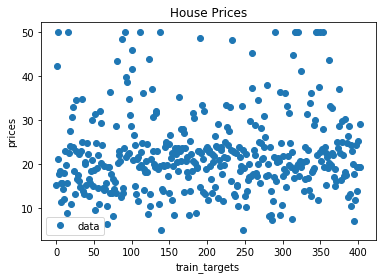

In [7]:
import matplotlib.pyplot as plt

x = range(len(train_targets))
y = train_targets

plt.plot(x, y, 'o', label='data')
plt.title('House Prices')
plt.xlabel('train_targets')
plt.ylabel('prices')
plt.legend()
plt.show()

### 数据准备

我们喂给神经网络的数据值的范围不应该差距太大，虽然神经网络是可以处理差距大的数据的，但总归不太好。
对于这种差距大的数据，我们一般都会对每个特征做标准化（feature-wise normalization）。

具体的操作是对每个特征（输入数据矩阵的一列）减去该列的均值，再除以其标准差。
这样做完之后，数据会变成以 0 为中心的，有一个标准差的（标准差为 1 ）。

用 Numpy 可以很容易的做这个：

In [8]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

注意哈，对测试集的处理用的是训练集的均值和标准差。

处理完数据就可以构建网络、训练了（标签不用处理，比分类方便）

### 构建网络

数据越少，越容易过拟合，要减缓过拟合，可以使用比较小的网络。

比如，在这个问题中，我们使用一个只有两个隐藏层的网络，每个 64 单元：

In [9]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation="relu", input_shape=(train_data.shape[1], )))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(1))
    
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    
    return model

网络的最后一层只有一个单元，并且没有激活函数（所以是个线性的层）。这种层是我们做连续单值回归问题的最后一步的标配。

如果加了激活函数，输出的值就会有范围限制，比如 sigmoid 会把值限制到 `[0, 1]`。没有激活函数，这个线性的层输出的值就没有限制了。

我们在编译模型时，使用的损失函数是 `mse` （mean squared error，均方误差）。这个函数返回预测和真实目标值的差的平方。回归问题多用这个损失。

然后我们还用了以前没用过的训练指标 —— `mae`（mean absolute error，平均绝对误差），这个东西是预测和真实目标的差的绝对值。

### 拟合验证 —— K-fold 验证

我们之前一直在做 —— 为了对网络进行评估，来调节网络参数(比如训练的轮数)，我们将数据划分为训练集和验证集。这一次，我们也需要这么做。
但有一点麻烦是，我们这次的数据太少了，所以分出来的验证集就很小（可能才有100条数据）。这种情况下，验证集选择的数据不同，可能对验证的结果有很大影响（即验证集的划分方式不同可能造成验证结果的方差很大），这种情况会影响我们对模型的验证。

在这种尴尬的境地，最佳实践是使用 *K-fold* 交叉验证（K折交叉验证）。

用 K-fold 验证，我们把数据分成 K 个部分（一般 k = 4 or 5），然后实例化 K 个独立的模型，每个用 K-1 份数据去训练，然后用剩余的一份去验证，最终模型的验证分数使用 K 个部分的平均值。

![K-fold 验证示意图](https://tva1.sinaimg.cn/large/007S8ZIlgy1gert24t4p8j317u0mstci.jpg)

K-fold 验证的代码实现：

In [10]:
# Load the TensorBoard notebook extension
# TensorBoard 可以可视化训练过程
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [22]:
import numpy as np
import datetime
import tensorflow as tf

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

# 准备 TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

for i in range(k):
    print(f'processing fold #{i} ({i+1}/{k})')
    
    # 准备验证数据
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # 准备训练数据
    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples],
         train_data[(i+1) * num_val_samples :]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[: i * num_val_samples], 
         train_targets[(i+1) *  num_val_samples :]], 
        axis=0)
    
    #构建、训练模型
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, 
              epochs=num_epochs, batch_size=1, verbose=0,
              callbacks=[tensorboard_callback])
    
    # 有验证集评估模型
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)


np.mean(all_scores)

processing fold #0 (1/4)
processing fold #1 (2/4)
processing fold #2 (3/4)
processing fold #3 (4/4)


2.4046657

In [23]:
%tensorboard --logdir logs/fit

刚才那个只是玩一下哈，现在我们改一下，迭代 500 轮，把训练的结果记下来：

In [43]:
k = 4
num_val_samples = len(train_data) // k

num_epochs = 500
all_mae_histories = []

for i in range(k):
    print(f'processing fold #{i} ({i+1}/{k})')
    
    # 准备验证数据
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # 准备训练数据
    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples],
         train_data[(i+1) * num_val_samples :]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[: i * num_val_samples], 
         train_targets[(i+1) *  num_val_samples :]], 
        axis=0)
    
    #构建、训练模型
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)

    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)


print("Done.")

processing fold #0 (1/4)
processing fold #1 (2/4)
processing fold #2 (3/4)
processing fold #3 (4/4)
Done.


In [44]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

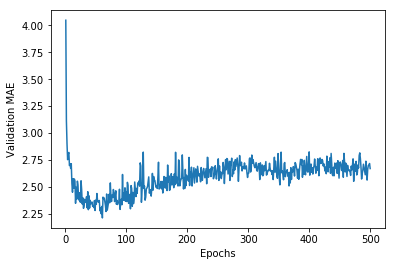

In [47]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

这个图太密了，看不清，所以要处理一下：

- 去掉前十组数据，这端明显和其他的数量差距比较大；
- 把每个点都换成前面数据点的指数移动平均值（an exponential moving average of the previous points），把曲线变平滑；

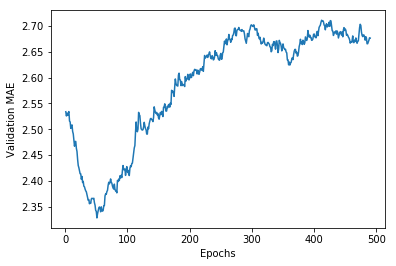

In [49]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

从这个图看，差不多过了 80 个 epochs 后就过拟合了。

在尝试了这些之后，我们找出最佳的参数（轮数啦，网络的层数啦，这些都可以试试），然后用最佳的参数在所有数据上训练，来得出最终的生产模型。

In [53]:
# 训练最终模型

model = build_model()
model.fit(train_data, train_targets, 
          epochs=80, batch_size=16, verbose=0)

# 最后评估一下
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets, verbose=0)
print(test_mse_score, test_mae_score)

17.43332971311083 2.6102107


这个 test_mae_score 的值说明，我们训练出来的模型的预测和实际大概差了 2k+ 美元。。。😭